In [100]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt 
from scipy.stats import shapiro 
from scipy.stats import lognorm

**Customer Churn Prediction- Binary Classification**

Reading the dataset

In [101]:
df = pd.read_csv('/content/Bank Customer Churn Prediction.csv')
# Visualize the dataframe
df

customer_id  credit_score  country  gender  age  tenure    balance  \
0        15634602           619   France  Female   42       2       0.00   
1        15647311           608    Spain  Female   41       1   83807.86   
2        15619304           502   France  Female   42       8  159660.80   
3        15701354           699   France  Female   39       1       0.00   
4        15737888           850    Spain  Female   43       2  125510.82   
...           ...           ...      ...     ...  ...     ...        ...   
9995     15606229           771   France    Male   39       5       0.00   
9996     15569892           516   France    Male   35      10   57369.61   
9997     15584532           709   France  Female   36       7       0.00   
9998     15682355           772  Germany    Male   42       3   75075.31   
9999     15628319           792   France  Female   28       4  130142.79   

      products_number  credit_card  active_member  estimated_salary  churn  
0                   1            1              1         101348.88      1  
1                   1            0              1         112542.58      0  
2                   3            1              0         113931.57      1  
3                   2            0              0          93826.63      0  
4                   1            1              1          79084.10      0  
...               ...          ...            ...               ...    ...  
9995                2            1              0          96270.64      0  
9996                1            1              1         101699.77      0  
9997                1            0              1          42085.58      1  
9998                2            1              0          92888.52      1  
9999                1            1              0          38190.78      0  

[10000 rows x 12 columns]

In [102]:
# Dataframe Description:
"""The dataset consists of two types of data features: categorical and numerical. "credit_card", "active_member", "gender" and "country" are categorical features while the remainder are 
numerical data. The final classification output is in the form of binary labels under the feature "churn" which indicates whether the customers churn or not. For training 
purposes, the "customer_id" of the user is irrelevant as it does not provide any information about whether the customer will churn. We will omit this feature while feeding into the model inputs.
The following code below (Shapiro-wilk test) will test whether each of the features are normally distributed. This will help in the pre-processing stage of the data. p-values less than 0.05 indicate that the feature
is not normally distributed.
"""

#perform Shapiro-Wilk test for normality: we see that none of them are normally distributed
print(shapiro(df['credit_score']))
print(shapiro(df['age']))
print(shapiro(df['tenure']))
print(shapiro(df['balance']))
print(shapiro(df['products_number']))

ShapiroResult(statistic=0.9939263463020325, pvalue=3.532837989895404e-20)
ShapiroResult(statistic=0.9441365003585815, pvalue=0.0)
ShapiroResult(statistic=0.9486214518547058, pvalue=0.0)
ShapiroResult(statistic=0.8455799221992493, pvalue=0.0)
ShapiroResult(statistic=0.7061033248901367, pvalue=0.0)


/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Retaining columns with features relevant to classification

In [103]:
# Removing features irrelevant to the classification task: customer_id
df_modified = df.drop(['customer_id'], axis=1)

# splitting columns into model inputs and output labels
X = df_modified.drop(['churn'], axis=1)
y = df_modified['churn']

# Creating a one-hot encoded vector of the categorical variables: gender and country
one_hot = pd.get_dummies(X['gender'])
X = X.drop('gender',axis = 1)
X = X.join(one_hot)
one_hot = pd.get_dummies(X['country'])
X = X.drop('country',axis = 1)
X = X.join(one_hot)

Train-test splitting

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42)

In [105]:
# Converting into arrays for using in the custom-ML model
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

Defining helper functions for logistic regression

In [106]:
def scores(y, pred):
    # Computes precision, recall, F1, and accuracy scores
    tp,tn,fp,fn = 0,0,0,0

    for i in range(len(y)):
        if y[i] == 1 and pred[i] == 1:
            tp += 1 # true positives
        elif y[i] == 1 and pred[i] == 0:
            fn += 1 # false negatives
        elif y[i] == 0 and pred[i] == 1:
            fp += 1 # false positives
        elif y[i] == 0 and pred[i] == 0:
            tn += 1 # true negatives
    precision = tp/(tp+fp) 
    recall = tp/(tp+fn)
    f1_score = 2*precision*recall/(precision+recall)
    accuracy = np.sum(np.equal(y, pred)) / len(y)
    return f1_score, precision, recall, accuracy

def standardize(X):
    for i in range(X.shape[1]):
        # min-max normalization because the numerical features are not normally distributed
        X[:, i] = (X[:, i] - X[:,i].min()) / (X[:,i].max() - X[:,i].min())
    return X

In [107]:
class LogReg:

    def sigmoid(self,z):
        sig = 1/(1 + np.exp(-z))
        return sig

    def initialize(self,X):
        weights = np.zeros((X.shape[1]+1,1))
        X = np.c_[np.ones((X.shape[0],1)),X]
        return weights, X

    def fit(self,X,y,alpha=0.0001,iter=800):
        weights, X = self.initialize(X)

        def cost(theta):
            z = np.dot(X,theta)
            cost0 = y.T.dot(np.log(self.sigmoid(z))) 
            cost1 = (1-y).T.dot(np.log(1-self.sigmoid(z)))
            cost = -((cost1 + cost0))/len(y)
            return cost

        cost_list = np.zeros(iter,)

        for i in range(iter):
            weights = weights - alpha*np.dot(X.T,self.sigmoid(np.dot(X,weights))-np.reshape(y,(len(y),1)))
            cost_list[i] = cost(weights)
        self.weights = weights
        return cost_list

    def predict(self,X):
        z = np.dot(self.initialize(X)[1],self.weights)
        predictions = [1 if (i>0.55).all() else 0 for i in self.sigmoid(z)]
        return predictions

Binary Classification- Model training

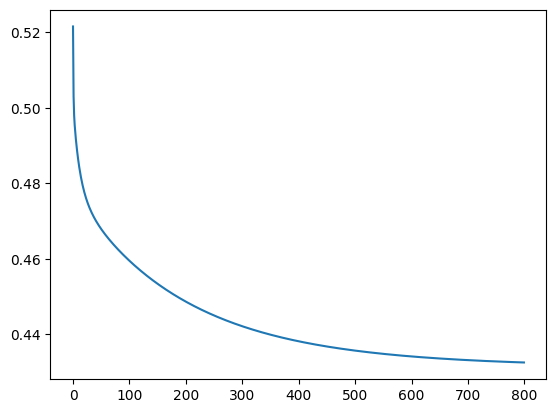

In [108]:
# standardize the inputs
X_train = standardize(X_train)
X_test = standardize(X_test)

# initilizes model
model = LogReg()
# model fit
costs = model.fit(X_train, y_train)

# generate predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# plotting the training costs
plt.plot(costs)

In [109]:
# compute scores
f1_score, precision, recall, acc = scores(y_train, train_predictions)
print(f1_score, precision, recall, acc)

f1_score, precision, recall, acc = scores(y_test, test_predictions)
print(f1_score, precision, recall, acc)

0.22256410256410256 0.7091503267973857 0.13199513381995134 0.8105
0.22964509394572027 0.6395348837209303 0.13994910941475827 0.8155


Model Comparison

In [110]:
# evaluate the performance of your model by comparing with an sklearn logistic_regression model
model = LogisticRegression(max_iter = 800) # model initialization
model.fit(X_train, y_train) # model fitting
predictions = model.predict(X_test) # generate predictions
accuracy = accuracy_score(predictions, y_test)
precision = precision_score(predictions, y_test)
recall = recall_score(predictions, y_test)
print(precision, recall, accuracy)

0.20610687022900764 0.5510204081632653 0.811


In [111]:
# Notes on model performance:
"""The model we built has good precision score but poor recall score. This means that the model
is returning very few results, but most of its predicted labels are correct when compared to the training labels. 
In order to improve the recall, we may lower the threshold values. However, the accuracy of our model is comparable
to the one provided by sklearn."""

'The model we built has good precision score but poor recall score. This means that the model\nis returning very few results, but most of its predicted labels are correct when compared to the training labels. \nIn order to improve the recall, we may lower the threshold values. However, the accuracy of our model is comparable\nto the one provided by sklearn.'